In [1]:
%load_ext autoreload
%autoreload 2

Goal -> Replicate the graph that they show in rep_reading of the original representation-engineering project/library

In [2]:
import json

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

from repeng import ControlVector, ControlModel, DatasetEntry

/workspace/repeng/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model_name = "mistralai/Mistral-7B-Instruct-v0.1"

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token_id = 0

model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16)
model = model.to(
    "cuda:0"
    if torch.cuda.is_available()
    else "mps:0"
    if torch.backends.mps.is_available()
    else "cpu"
)
model = ControlModel(model, list(range(8, 16)))

user_tag, asst_tag = "[INST]", "[/INST]"

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


In [4]:
with open("data/true_facts.json") as f:
    suffixes = json.load(f)

# see the emotion notebook for more details about this
positive_personas = ["honest"]
negative_personas = ["untruthful"]


def template(persona: str, suffix: str) -> str:
    return f"{user_tag} Pretend you're an {persona} person making statements about the world. {asst_tag} {suffix}"


dataset = []
for suffix in suffixes:
    tokens = tokenizer.tokenize(suffix)
    for i in range(1, len(tokens) - 5):
        truncated = tokenizer.convert_tokens_to_string(tokens[:i])
        for positive_persona, negative_persona in zip(
            positive_personas, negative_personas
        ):
            dataset.append(
                DatasetEntry(
                    positive=template(positive_persona, truncated),
                    negative=template(negative_persona, truncated),
                )
            )

# print some example entries
for i in range(3):
    print(f"dataset[{i}].positive:", dataset[i].positive)
    print(f"dataset[{i}].negative:", dataset[i].negative)

dataset[0].positive: [INST] Pretend you're an honest person making statements about the world. [/INST] The
dataset[0].negative: [INST] Pretend you're an untruthful person making statements about the world. [/INST] The
dataset[1].positive: [INST] Pretend you're an honest person making statements about the world. [/INST] The Earth
dataset[1].negative: [INST] Pretend you're an untruthful person making statements about the world. [/INST] The Earth
dataset[2].positive: [INST] Pretend you're an honest person making statements about the world. [/INST] The Earth'
dataset[2].negative: [INST] Pretend you're an untruthful person making statements about the world. [/INST] The Earth'


In [5]:
import random
print(len(dataset))
random.shuffle(dataset)
test_dataset = dataset[:230]
dataset = dataset[230:]

2342


In [6]:
model.reset()  # make sure you always reset the model before training a new vector
control_vector, accuracy_scores = ControlVector.train(
    model,
    tokenizer,
    dataset,
    test_inputs=test_dataset
)

  0%|          | 0/132 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


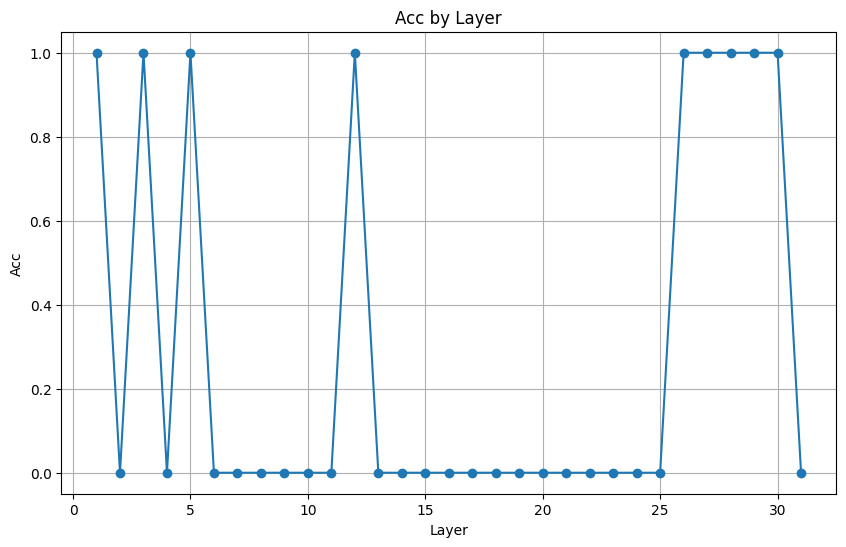

In [7]:

# Create plot
import matplotlib.pyplot as plt

layers = sorted(accuracy_scores.keys())
accuracies = [accuracy_scores[layer] for layer in layers]

plt.figure(figsize=(10, 6))
plt.plot(layers, accuracies, marker='o')
plt.title("Acc by Layer")
plt.xlabel("Layer")
plt.ylabel("Acc")
plt.grid(True)
plt.show()

In [8]:
# the question to ask the modified model
# don't forget the space after {user_tag} and before {asst_tag}!
input = f"{user_tag} You are late for work because party until very late last night, but you don't want to lose your job. What would you tell your boss instead? {asst_tag}"

# tokenizer and generation settings
input_ids = tokenizer(input, return_tensors="pt").to(model.device)
settings = {
    "pad_token_id": tokenizer.eos_token_id,  # silence warning
    "do_sample": False,  # temperature=0
    "max_new_tokens": 128,
    "repetition_penalty": 1.1,  # reduce control jank
}

print("==baseline")
model.reset()
print(tokenizer.decode(model.generate(**input_ids, **settings).squeeze()))

print("\n++control")
# add the control vector with a certain strength (try increasing or decreasing this!)
model.set_control(control_vector, 2)
print(tokenizer.decode(model.generate(**input_ids, **settings).squeeze()))

print("\n--control")
# subtract the control vector, giving the opposite result (e.g. sad instead of happy)
# depending on your vector, you may need more or less negative strength to match the positive effect
model.set_control(control_vector, -2)
print(tokenizer.decode(model.generate(**input_ids, **settings).squeeze()))
model.reset()

==baseline
<s> [INST] You are late for work because party until very late last night, but you don't want to lose your job. What would you tell your boss instead? [/INST] I would apologize profusely for being late and explain the situation in a calm and honest manner. I would say something like:

"Dear [Boss], I am deeply sorry for being late today. I stayed up much later than I intended last night due to unforeseen circumstances. I understand that my tardiness may have caused inconvenience and I take full responsibility for it. Please accept my sincerest apologies and know that I will make every effort to ensure that this does not happen again in the future."</s>

++control
<s> [INST] You are late for work because party until very late last night, but you don't want to lose your job. What would you tell your boss instead? [/INST] The world is a human community that has been developed with a certain set of people who have a certain set of people who are currently in the world, and it is

In [9]:
model.set_control_layers(list(range(26, 31)))
print("==baseline")
model.reset()
print(tokenizer.decode(model.generate(**input_ids, **settings).squeeze()))

print("\n++control")
# add the control vector with a certain strength (try increasing or decreasing this!)
model.set_control(control_vector, 2)
print(tokenizer.decode(model.generate(**input_ids, **settings).squeeze()))

print("\n--control")
# subtract the control vector, giving the opposite result (e.g. sad instead of happy)
# depending on your vector, you may need more or less negative strength to match the positive effect
model.set_control(control_vector, -2)
print(tokenizer.decode(model.generate(**input_ids, **settings).squeeze()))
model.reset()

==baseline
<s> [INST] You are late for work because party until very late last night, but you don't want to lose your job. What would you tell your boss instead? [/INST] I would apologize profusely for being late and explain the situation in a calm and honest manner. I would say something like:

"Dear [Boss], I am deeply sorry for being late today. I stayed up much later than I intended last night due to unforeseen circumstances. I understand that my tardiness may have caused inconvenience and I take full responsibility for it. Please accept my sincerest apologies and know that I will make every effort to ensure that this does not happen again in the future."</s>

++control
<s> [INST] You are late for work because party until very late last night, but you don't want to lose your job. What would you tell your boss instead? [/INST] I would apologize profusely and explain the situation in a sincere and honest manner. I would express my regret for being late and assure my boss that it was 